In [14]:
#Imports
import zipfile
import json
import os
import random
import shutil
import cv2
import numpy as np
import tensorflow as tf
from sklearn.metrics import average_precision_score
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.models import load_model, Model
from google.colab.patches import cv2_imshow
from collections import Counter

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
zip_file_name = "/content/drive/MyDrive/human_activity_retrieval_dataset.zip"
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('unzipped_images')

# Load the model

In [17]:
model = load_model('/content/drive/MyDrive/dataset_challenging/model_weights (2).h5')

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 260, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 200, 260, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 200, 260, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 200, 260, 3)          0         ['normalization[0][0]'] 

In [19]:

def cosine_similarity(vector1, vector2):
    """
    Calculate the cosine similarity between two vectors.

    Parameters:
    - vector1: The first vector (NumPy array).
    - vector2: The second vector (NumPy array).

    Returns:
    - similarity: The cosine similarity between the two vectors.
    """
    # Ensure that the vectors are 1D arrays
    vector1 = vector1.flatten()
    vector2 = vector2.flatten()

    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)

    # Handle cases where the denominator is close to zero
    if norm_vector1 == 0 or norm_vector2 == 0:
        return 0.0  # Cosine similarity is undefined

    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity


In [20]:

# Load test.json to get image names and labels
with open('/content/unzipped_images/human_activity_retrieval_dataset/test_image_info.json', 'r') as json_file:
    test_data = json.load(json_file)

# Directory path to the gallery images
gallery_dir = '/content/unzipped_images/human_activity_retrieval_dataset/gallery'  # Adjust the path as needed

# Directory path to the query images
query_dir = '/content/unzipped_images/human_activity_retrieval_dataset/query_images'  # Adjust the path as needed

# Initialize lists to store labels and image filenames
gallery_labels = []
gallery_image_filenames = []
query_labels = []
query_image_filenames = []

# Precompute and store predictions for gallery images
gallery_predictions = []

for filename in os.listdir(gallery_dir):
    if filename in test_data:
        label = test_data[filename]
        gallery_labels.append(label)
        gallery_image_filenames.append(filename)

        # Load and preprocess the gallery image
        gallery_image_path = os.path.join(gallery_dir, filename)
        gallery_image = cv2.imread(gallery_image_path)
        gallery_image = cv2.resize(gallery_image, (260, 200))  # Adjust target size
        gallery_image = gallery_image / 255.0  # Normalize to [0, 1] range (if necessary)

        # Predict class probabilities for the gallery image
        gallery_probs = model.predict(np.expand_dims(gallery_image, axis=0))
        gallery_predictions.append(gallery_probs)

# Process query images and associate labels
for filename in os.listdir(query_dir):
    if filename in test_data:
        label = test_data[filename]
        query_labels.append(label)
        query_image_filenames.append(filename)

print("Gallery images: ", len(gallery_image_filenames))
print("Query images: ", len(query_image_filenames))



1/1 [==============================] - 0s 152ms/step
Gallery images:  1000
Query images:  150


In [21]:
# Initialize lists to store evaluation metrics
map_values = []
mean_rank_values = []

# Initialize query_similarity_scores to store similarity scores for each query
query_similarity_scores = []

# Loop through each query image
for query_index, query_image_filename in enumerate(query_image_filenames):
    # Load and preprocess the query image
    query_image_path = os.path.join(query_dir, query_image_filename)
    query_image = cv2.imread(query_image_path)
    query_image = cv2.resize(query_image, (260, 200))  # Adjust target size
    query_image = query_image / 255.0  # Normalize to [0, 1] range (if necessary)

    print(query_image.shape)
    # Predict the class probabilities for the query image using the trained model
    query_probs = model.predict(np.expand_dims(query_image, axis=0))

    # Access precomputed gallery predictions
    gallery_probs_list = gallery_predictions

    # Calculate similarity scores between query and gallery images using precomputed predictions
    similarity_scores = [cosine_similarity(query_probs, gallery_probs) for gallery_probs in gallery_probs_list]

    # Append the similarity scores for the current query image to the list
    query_similarity_scores.append(similarity_scores)

    # Sort gallery images by similarity score (higher is better)
    sorted_indices = np.argsort(similarity_scores)[::-1]
    sorted_labels = [gallery_labels[i] for i in sorted_indices]

    # Calculate Average Precision (AP) for the current query
    relevant_indices = [i for i, label in enumerate(sorted_labels) if label == query_labels[query_index]]

    if len(relevant_indices) > 0:
        true_labels = [1 if i in relevant_indices else 0 for i in range(len(sorted_labels))]
        sorted_similarity_scores = [similarity_scores[i] for i in sorted_indices]
        ap = average_precision_score(true_labels, sorted_similarity_scores)
    else:
        ap = 0.0

    # Calculate Mean Rank for the current query
    mean_rank = sorted_labels.index(query_labels[query_index]) + 1

    # Append metrics to the lists
    map_values.append(ap)
    mean_rank_values.append(mean_rank)

(200, 260, 3)
1/1 [==============================] - 0s 152ms/step
(200, 260, 3)
1/1 [==============================] - 0s 156ms/step
(200, 260, 3)
1/1 [==============================] - 0s 152ms/step
(200, 260, 3)
1/1 [==============================] - 0s 166ms/step
(200, 260, 3)
1/1 [==============================] - 0s 154ms/step
(200, 260, 3)
1/1 [==============================] - 0s 153ms/step
(200, 260, 3)
1/1 [==============================] - 0s 150ms/step
(200, 260, 3)
1/1 [==============================] - 0s 149ms/step
(200, 260, 3)
1/1 [==============================] - 0s 150ms/step
(200, 260, 3)
1/1 [==============================] - 0s 149ms/step
(200, 260, 3)
1/1 [==============================] - 0s 166ms/step
(200, 260, 3)
1/1 [==============================] - 0s 151ms/step
(200, 260, 3)
1/1 [==============================] - 0s 152ms/step
(200, 260, 3)
1/1 [==============================] - 0s 155ms/step
(200, 260, 3)
1/1 [==============================] - 0s 169ms/

In [22]:
# Calculate and print Mean Average Precision (mAP)
mAP = np.mean(map_values)
print(f"Mean Average Precision (mAP): {mAP}")

# Calculate and print Mean Rank
mean_rank = np.mean(mean_rank_values)
print(f"Mean Rank: {mean_rank}")

# Calculate mAP at different values of K (e.g., K = 1, 10, 50)
k_values = [1, 10, 50]
# Calculate Mean Average Precision (mAP) at specified values of K
map_at_k_values = []

for k in k_values:
    # Calculate mAP at K for each query
    ap_at_k_values = []
    for query_index, query_similarity_score in enumerate(query_similarity_scores):
        top_k_indices = np.argsort(query_similarity_score)[::-1][:k]
        top_k_labels = [gallery_labels[i] for i in top_k_indices]

        # Calculate Average Precision (AP) at K for the current query
        relevant_indices = [i for i, label in enumerate(top_k_labels) if label == query_labels[query_index]]

        if len(relevant_indices) > 0:
            true_labels = [1 if i in relevant_indices else 0 for i in range(len(top_k_labels))]
            sorted_similarity_scores = [query_similarity_score[i] for i in top_k_indices]  # Sort similarity scores in descending order
            ap_at_k = average_precision_score(true_labels, sorted_similarity_scores)  # Corrected
        else:
            ap_at_k = 0.0  # Set AP to 0 if there are no relevant items in the top K

        ap_at_k_values.append(ap_at_k)

    # Calculate Mean Average Precision (mAP) at K across all queries
    map_at_k = np.mean(ap_at_k_values)
    map_at_k_values.append(map_at_k)

# mAP at specified K values and Mean Rank values
print(f"Mean Average Precision (mAP) at K={k_values}: {map_at_k_values}")
print(f"Mean Rank values: {mean_rank_values}")

Mean Average Precision (mAP): 0.6433627455831996
Mean Rank: 6.42
Mean Average Precision (mAP) at K=[1, 10, 50]: [0.6866666666666666, 0.7558478563030152, 0.7455574970386111]
Mean Rank values: [1, 4, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 40, 37, 1, 1, 3, 61, 85, 2, 1, 2, 1, 83, 1, 1, 12, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 11, 1, 1, 2, 2, 2, 42, 45, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 7, 1, 2, 3, 1, 2, 7, 8, 59, 1, 4, 1, 1, 39, 1, 7, 2, 1, 1, 1, 1, 39, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 55, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 37, 12, 26, 1, 44, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 44, 1, 1, 1, 1, 1, 2]


# Query the image


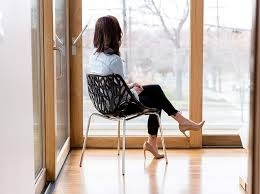

Query Image: Label=sitting
1/1 [==============================] - 0s 238ms/step


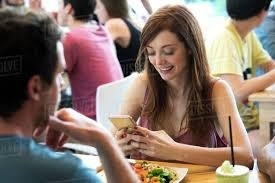

Gallery Image 1: Label=texting, Similarity Score=1.00


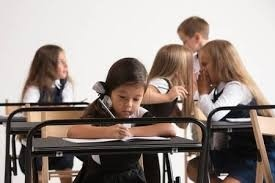

Gallery Image 2: Label=sitting, Similarity Score=1.00


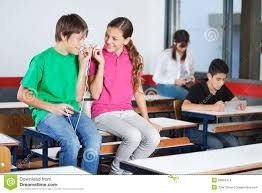

Gallery Image 3: Label=listening_to_music, Similarity Score=1.00


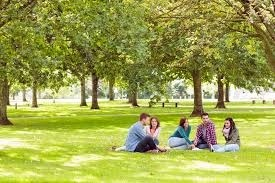

Gallery Image 4: Label=sitting, Similarity Score=1.00


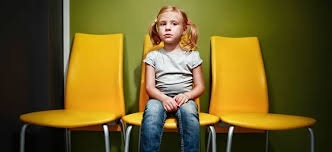

Gallery Image 5: Label=sitting, Similarity Score=1.00


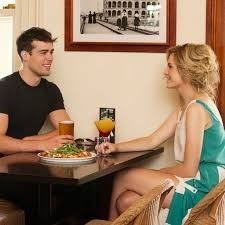

Gallery Image 6: Label=eating, Similarity Score=1.00


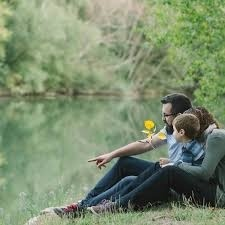

Gallery Image 7: Label=sitting, Similarity Score=1.00


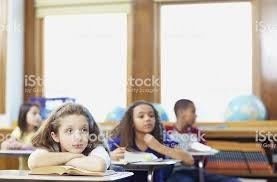

Gallery Image 8: Label=sitting, Similarity Score=1.00


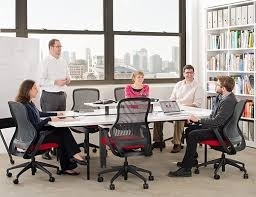

Gallery Image 9: Label=sitting, Similarity Score=1.00


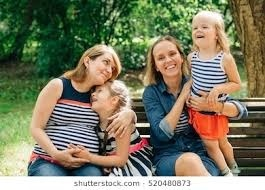

Gallery Image 10: Label=sitting, Similarity Score=1.00


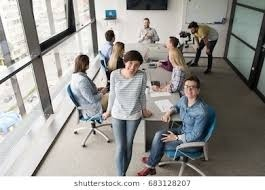

Gallery Image 11: Label=sitting, Similarity Score=1.00


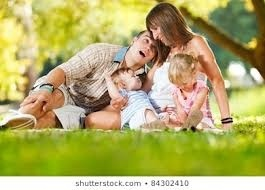

Gallery Image 12: Label=sitting, Similarity Score=1.00


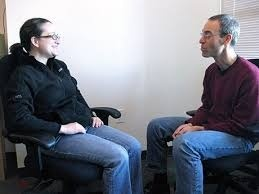

Gallery Image 13: Label=sitting, Similarity Score=1.00


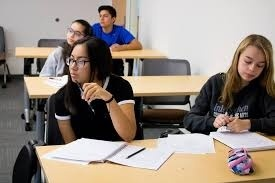

Gallery Image 14: Label=sitting, Similarity Score=1.00


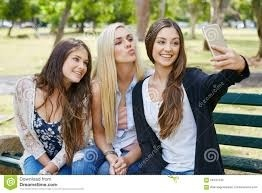

Gallery Image 15: Label=sitting, Similarity Score=1.00


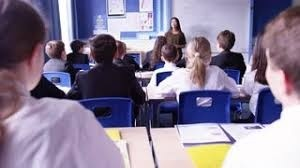

Gallery Image 16: Label=sitting, Similarity Score=1.00


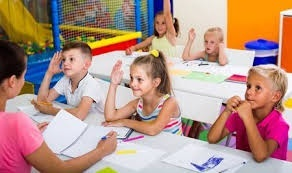

Gallery Image 17: Label=sitting, Similarity Score=1.00


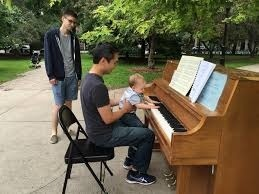

Gallery Image 18: Label=sitting, Similarity Score=1.00


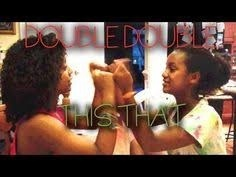

Gallery Image 19: Label=clapping, Similarity Score=1.00


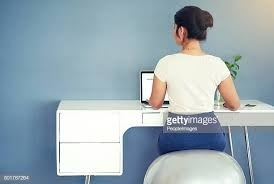

Gallery Image 20: Label=sitting, Similarity Score=1.00


In [23]:

# Function to calculate similarity score
def calculate_similarity(query_probs, gallery_probs):
    similarity_score = np.dot(query_probs, gallery_probs.T)
    return similarity_score

# Load and preprocess the query image
query_image_filename = 'Image_10750.jpg'
query_image_path = os.path.join(query_dir, query_image_filename) # Replace with the path to your query image
query_image = cv2.imread(query_image_path)

# Display the query image
cv2_imshow(query_image)
print(f"Query Image: Label={test_data[query_image_filename]}")

query_image = cv2.resize(query_image, (260, 200))  # Adjust target size
query_image = query_image / 255.0  # Normalize to [0, 1] range

# Predict class probabilities for the query image
query_probs = model.predict(np.expand_dims(query_image, axis=0))

# Initialize lists to store relevant images and their similarity scores
relevant_images = []
similarity_scores = []

# Loop through each gallery image and calculate similarity scores
for gallery_probs in gallery_predictions:
    # Calculate the similarity score
    similarity_score = cosine_similarity(query_probs, gallery_probs)
    similarity_scores.append(similarity_score)

# Sort gallery images by similarity score (higher is better)
sorted_indices = np.argsort(similarity_scores)[::-1]
sorted_labels = [gallery_labels[i] for i in sorted_indices]

# Display the top 20 relevant images and their information
top_k = 20
for i in range(top_k):
    gallery_image_filename = gallery_image_filenames[sorted_indices[i]]
    similarity_score = similarity_scores[sorted_indices[i]]
    gallery_label = sorted_labels[i]

    # Load and display the gallery image
    gallery_image_path = os.path.join(gallery_dir, gallery_image_filename)
    gallery_image = cv2.imread(gallery_image_path)

    # Display the gallery image
    cv2_imshow(gallery_image)
    print(f"Gallery Image {i+1}: Label={gallery_label}, Similarity Score={similarity_score:.2f}")
